# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.decomposition import PCA
from numpy import trapz

from tsne_modifications.dataset_generations.synthesize import synthesize_8_4_4, synthesize_4_2_2
from tsne_modifications.jedi import JEDI
from tsne_modifications.metrics.metrics import nos
from tsne_modifications.dtsne import DTSNE
from tsne_modifications.utils import get_distance_matrix
import warnings
warnings.filterwarnings('ignore')
# Set random seed for reproducibility
np.random.seed(42)

# JEDI Experiments

In this notebook we compare 4 methods for making low-dimensional embeddings with prior knowledge:
* ISOMAP
* t-SNE
* dt-SNE
* JEDI

To generate data, we will use the methods described in the article (https://arxiv.org/pdf/2103.01828.pdf) and below.

<h4> First dataset </h4>

 We first consider synthetic data with known ground truth. In particular, we consider synthetic data of n = 1000.
 The data has 14 dimensions in total, where each sample belongs to one of 4 clusters (A1-A4) in dimension 1-8 and one of four clusters in dimension 9-12 (B1-B4). We first draw cluster centers from $\mathcal{N}(0, 2)$ for each of the eight clusters. Then, the feature values for each sample are generated in three steps as follows:

   1. Pick a cluster a from A1-A4 with probability 0.1, 0.2, 0.3, or 0.4, respectively. Add Gaussian noise to the cluster center a with standard deviation 0.05, 0.1, 0.15, or 0.2, respectively. Noise is drawn and added for each dimension independently.
   2. Pick a cluster a from B1-B4 with probability 0.1, 0.2, 0.3, or 0.4, respectively. Add Gaussian noise to the cluster center a with standard deviation 0.05, 0.1, 0.15, or 0.2, respectively. Noise is drawn and added for each dimension independently.
   3. The remaining 2 dimensions of every sample are Gaussian noise from $\mathcal{N}(0, 0.1)$.
  
We will use Euclidean distance of first 8 dimensions as prior knowledge.
 
<h4> Second dataset </h4>

We gererate 10-dimensional data of n = 1000 with samples assigned to one of four clusters in the first 4 dimensions, and one of two clusters in dimension 5 and 6. The clusters in the first 4 dimensions are centered at the four unit vectors along the four axes of the dimensions. The clusters in the other dimensions are centered at
$[\frac{1}{3}; 0]$ and $[0; \frac{1}{3}]$. The remaining four dimensions are gaussian noise $\mathcal{N}(0, 0.01)$. Each data point is randomly assigned to one cluster of the first four, and one cluster in dimension 5 and 6, and takes the coordinates of the cluster centers plus some gaussian noise $\mathcal{N}(0, 0.01)$

We will use Euclidean distance of first 4 dimensions as prior knowledge.

<h4> Metric </h4>

To objectively quantify how well prior knowledge is factored out from an embedding, we measure the
similarity over neighborhoods. For two distance matrices $D, D'$ and neighborhood size $k$, we define the neighbourhood overlap score (NOS) as
$$NOS(D, D', k) = \frac{1}{k} \frac{1}{n} \sum_{i=1}^n | \{\text{kNN of} \; i \; \text{in} \; D\} \cap \{\text{kNN of} \; i \; \text{in} \: D'\}|$$

Plotting $NOS(D_X , D_Z, )$ for all neighborhood sizes $k = 1, . . . ,n$ allows us to asses how well we factor out prior knowledge from an embedding. As the id-line corresponds to a random neighbor encounter, we can measure the area under the NOS curve as a proxy for how well we preserve information, respectively how well we factor out prior knowledge.

<h4> Symbols on the charts </h4>

Shape (circle, square, triangle, and cross) correspond to cluster assignment over first dimensions (prior informatoin), colors to cluster assignment over other dimensions (our target).

<h3> Fisrt dataset </h3>

In [2]:
size = 1200
X_1, y_1, y_wrong_1 = synthesize_8_4_4(size, 42)

In [3]:
def run_experiment_jedi(X, y, perplexity=400.0, early_exaggeration=12.0, learning_rate="auto",
                    n_iter=1000, n_iter_without_progress=300, min_grad_norm=1e-7,
                    alpha=0.5, beta=0.95, verbose=0, random_state=None):
    
    #Set prior information as first 8 dimensions
    P_prior = squareform(get_distance_matrix(X[:, :8]))
    X = get_distance_matrix(X)
    model = JEDI(perplexity=perplexity, early_exaggeration=early_exaggeration, 
                 learning_rate=learning_rate, n_iter=n_iter, 
                 n_iter_without_progress=n_iter_without_progress, 
                 min_grad_norm=min_grad_norm, alpha=alpha, beta=beta, verbose=verbose, 
                 random_state=random_state)
    
    embedding = model.fit_transform(X, P_prior)
    
    return embedding, y

In [4]:
def plot(X, y, y_wrong):
    metric_df = pd.DataFrame({})
    X_nos = get_distance_matrix(X[:, 8:])
    marker = {1: "o", 2: "*", 3: "s", 4: "v"}

    fig, axs = plt.subplots(2, 2, figsize=(10, 6))

    embedding, y = run_experiment_jedi(X, y)
    for mar in np.unique(y_wrong):
        idx = np.where(y_wrong == mar)[0]
        embedding_now = embedding[idx]
        c_now = np.array(y)[idx]
        axs[0, 0].scatter(embedding_now[:, 0], embedding_now[:, 1], c=c_now, s=5, marker=marker[mar])
    axs[0, 0].set_title("JEDI")
    
    emb_dist = get_distance_matrix(embedding)
    metric_df["JEDI"] = nos(X_nos, emb_dist)
    
    model = DTSNE(perplexity=30, n_jobs=-1, verbose=0)
    embedding = model.fit_transform(X)
    for mar in np.unique(y_wrong):
        idx = np.where(y_wrong == mar)[0]
        embedding_now = embedding[idx]
        c_now = np.array(y)[idx]
        axs[0, 1].scatter(embedding_now[:, 0], embedding_now[:, 1], c=c_now, s=5, marker=marker[mar])
    axs[0, 1].set_title("DTSNE")
    emb_dist = get_distance_matrix(embedding)
    metric_df["DTSNE"] = nos(X_nos, emb_dist)
    
    
    isomap = Isomap(n_components=2)
    embedding = isomap.fit_transform(X)
    for mar in np.unique(y_wrong):
        idx = np.where(y_wrong == mar)[0]
        embedding_now = embedding[idx]
        c_now = np.array(y)[idx]
        axs[1, 0].scatter(embedding_now[:, 0], embedding_now[:, 1], c=c_now, s=5, marker=marker[mar])
    axs[1, 0].set_title("Isomap")
    emb_dist = get_distance_matrix(embedding)
    metric_df["Isomap"] = nos(X_nos, emb_dist)
        
    
    tsne = TSNE(n_components=2, random_state=42)
    embedding = tsne.fit_transform(X)
    for mar in np.unique(y_wrong):
        idx = np.where(y_wrong == mar)[0]
        embedding_now = embedding[idx]
        c_now = np.array(y)[idx]
        axs[1, 1].scatter(embedding_now[:, 0], embedding_now[:, 1], c=c_now, s=5, marker=marker[mar])
    axs[1, 1].set_title("TSNE")
    emb_dist = get_distance_matrix(embedding)
    metric_df["TSNE"] = nos(X_nos, emb_dist)
    
    metric_df.index = range(X.shape[0]-1)

    plt.tight_layout()
    plt.show()
    return metric_df

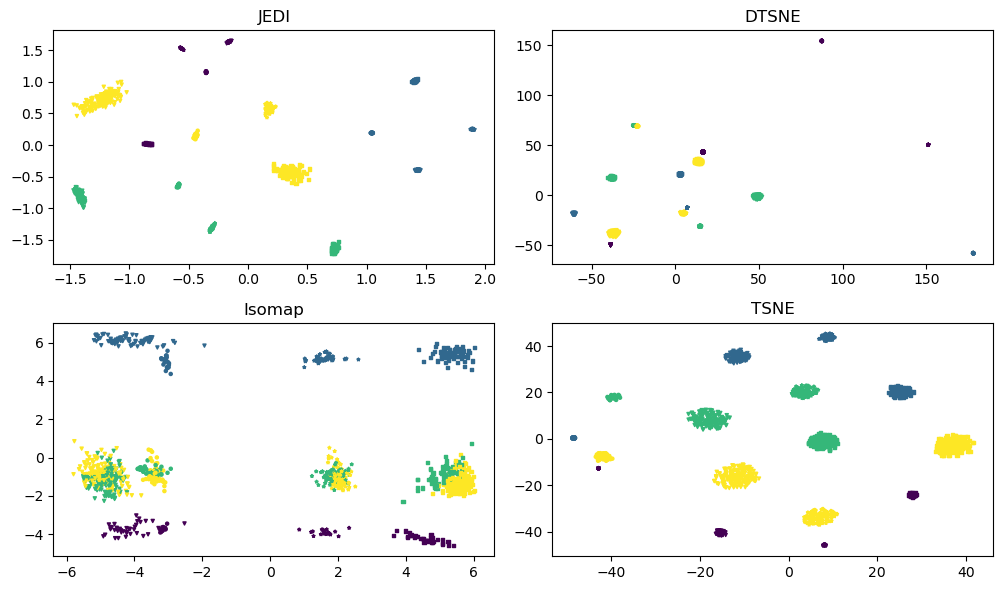

In [5]:
df_metric = plot(X_1, y_1, y_wrong_1)

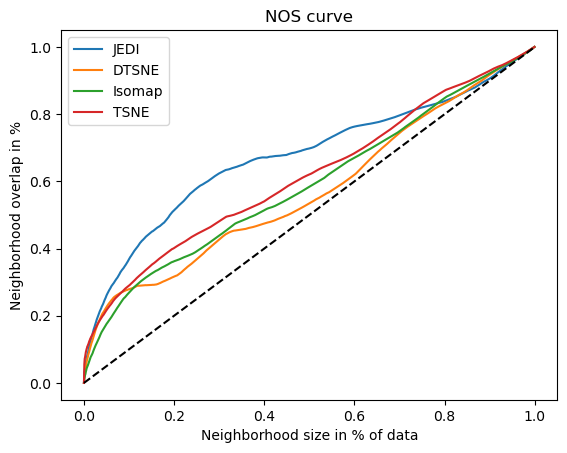

In [6]:
x_tick = np.array(df_metric.index) / len(df_metric.index)

plt.plot(x_tick, df_metric["JEDI"], label="JEDI")
plt.plot(x_tick, df_metric["DTSNE"], label="DTSNE")
plt.plot(x_tick, df_metric["Isomap"], label="Isomap")
plt.plot(x_tick, df_metric["TSNE"], label="TSNE")
plt.plot([0, 1], [0, 1], '--', color="black")
plt.xlabel("Neighborhood size in % of data")
plt.ylabel("Neighborhood overlap in %")
plt.title("NOS curve")
plt.legend()

In [7]:
area = trapz(df_metric["JEDI"], dx=1/len(df_metric["JEDI"]))
print(f"JEDI area under the NOS curve: {round(area, 4)}")

area = trapz(df_metric["DTSNE"], dx=1/len(df_metric["DTSNE"]))
print(f"DTSNE area under the NOS curve: {round(area, 4)}")

area = trapz(df_metric["Isomap"], dx=1/len(df_metric["Isomap"]))
print(f"Isomap area under the NOS curve: {round(area, 4)}")

area = trapz(df_metric["TSNE"], dx=1/len(df_metric["TSNE"]))
print(f"TSNE area under the NOS curve: {round(area, 4)}")

JEDI area under the NOS curve: 0.6735
DTSNE area under the NOS curve: 0.5695
Isomap area under the NOS curve: 0.5878
TSNE area under the NOS curve: 0.6149


<h3> Second dataset </h3>

In [8]:
size = 1000
X_1, y_1, y_wrong_1 = synthesize_4_2_2(size, 100)

In [9]:
def run_experiment_jedi(X, y, perplexity=30.0, early_exaggeration=12.0, learning_rate="auto",
                    n_iter=1000, n_iter_without_progress=300, min_grad_norm=1e-7,
                    alpha=0.5, beta=0.9, verbose=0, random_state=None):
    
    #Set prior information as first 4 dimensions
    P_prior = squareform(get_distance_matrix(X[:, :4]))
    X = get_distance_matrix(X)
    model = JEDI(perplexity=perplexity, early_exaggeration=early_exaggeration, 
                 learning_rate=learning_rate, n_iter=n_iter, 
                 n_iter_without_progress=n_iter_without_progress, 
                 min_grad_norm=min_grad_norm, alpha=alpha, beta=beta, verbose=verbose, 
                 random_state=random_state)
    
    embedding = model.fit_transform(X, P_prior)
    
    return embedding, y

In [10]:
def plot(X, y, y_wrong):
    metric_df = pd.DataFrame({})
    X_nos = get_distance_matrix(X[:, 4:])
    marker = {1: "o", 2: "*", 3: "s", 4: "v"}

    fig, axs = plt.subplots(2, 2, figsize=(10, 6))

    embedding, y = run_experiment_jedi(X, y)
    for mar in np.unique(y_wrong):
        idx = np.where(y_wrong == mar)[0]
        embedding_now = embedding[idx]
        c_now = np.array(y)[idx]
        axs[0, 0].scatter(embedding_now[:, 0], embedding_now[:, 1], c=c_now, s=5, marker=marker[mar])
    axs[0, 0].set_title("JEDI")
    
    emb_dist = get_distance_matrix(embedding)
    metric_df["JEDI"] = nos(X_nos, emb_dist)
    
    model = DTSNE(perplexity=30, n_jobs=-1, verbose=0)
    embedding = model.fit_transform(X)
    for mar in np.unique(y_wrong):
        idx = np.where(y_wrong == mar)[0]
        embedding_now = embedding[idx]
        c_now = np.array(y)[idx]
        axs[0, 1].scatter(embedding_now[:, 0], embedding_now[:, 1], c=c_now, s=5, marker=marker[mar])
    axs[0, 1].set_title("DTSNE")
    emb_dist = get_distance_matrix(embedding)
    metric_df["DTSNE"] = nos(X_nos, emb_dist)
    
    
    isomap = Isomap(n_components=2)
    embedding = isomap.fit_transform(X)
    for mar in np.unique(y_wrong):
        idx = np.where(y_wrong == mar)[0]
        embedding_now = embedding[idx]
        c_now = np.array(y)[idx]
        axs[1, 0].scatter(embedding_now[:, 0], embedding_now[:, 1], c=c_now, s=5, marker=marker[mar])
    axs[1, 0].set_title("Isomap")
    emb_dist = get_distance_matrix(embedding)
    metric_df["Isomap"] = nos(X_nos, emb_dist)
        
    
    tsne = TSNE(n_components=2, random_state=42)
    embedding = tsne.fit_transform(X)
    for mar in np.unique(y_wrong):
        idx = np.where(y_wrong == mar)[0]
        embedding_now = embedding[idx]
        c_now = np.array(y)[idx]
        axs[1, 1].scatter(embedding_now[:, 0], embedding_now[:, 1], c=c_now, s=5, marker=marker[mar])
    axs[1, 1].set_title("TSNE")
    emb_dist = get_distance_matrix(embedding)
    metric_df["TSNE"] = nos(X_nos, emb_dist)
    
    metric_df.index = range(X.shape[0]-1)

    plt.tight_layout()
    plt.show()
    return metric_df

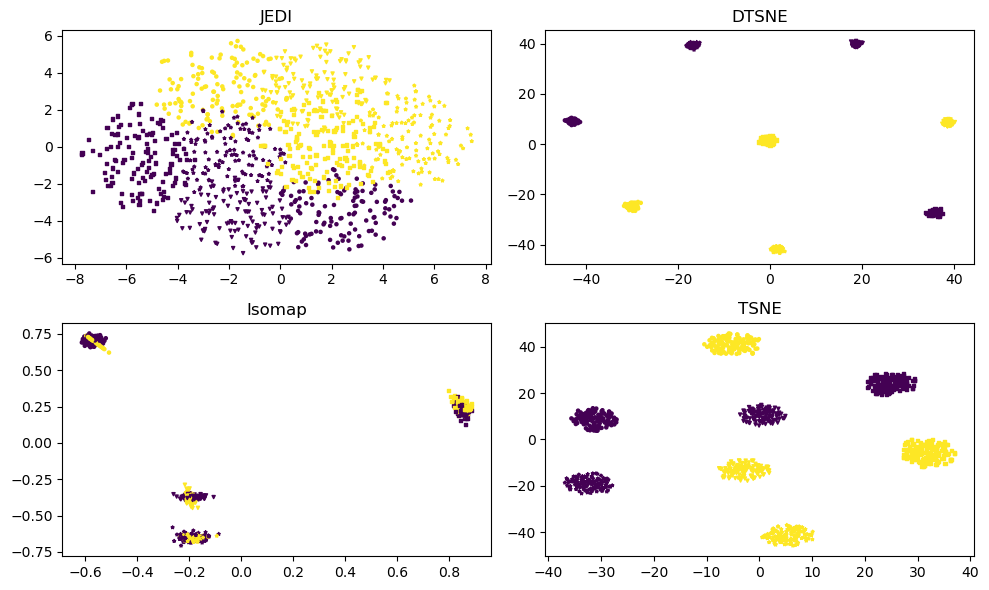

In [11]:
df_metric = plot(X_1, y_1, y_wrong_1)

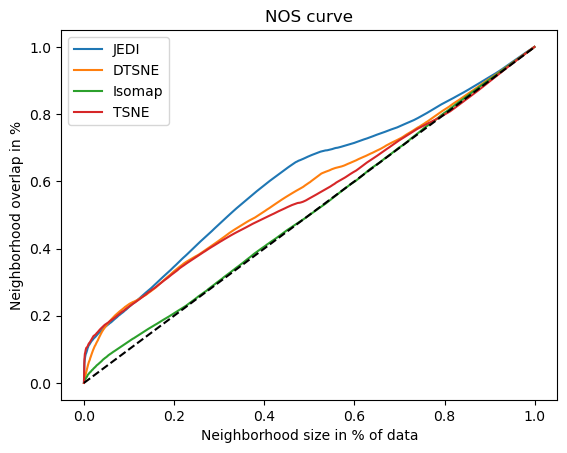

In [12]:
x_tick = np.array(df_metric.index) / len(df_metric.index)

plt.plot(x_tick, df_metric["JEDI"], label="JEDI")
plt.plot(x_tick, df_metric["DTSNE"], label="DTSNE")
plt.plot(x_tick, df_metric["Isomap"], label="Isomap")
plt.plot(x_tick, df_metric["TSNE"], label="TSNE")
plt.plot([0, 1], [0, 1], '--', color="black")
plt.xlabel("Neighborhood size in % of data")
plt.ylabel("Neighborhood overlap in %")
plt.title("NOS curve")
plt.legend()

In [13]:
area = trapz(df_metric["JEDI"], dx=1/len(df_metric["JEDI"]))
print(f"JEDI area under the NOS curve: {round(area, 4)}")

area = trapz(df_metric["DTSNE"], dx=1/len(df_metric["DTSNE"]))
print(f"DTSNE area under the NOS curve: {round(area, 4)}")

area = trapz(df_metric["Isomap"], dx=1/len(df_metric["Isomap"]))
print(f"Isomap area under the NOS curve: {round(area, 4)}")

area = trapz(df_metric["TSNE"], dx=1/len(df_metric["TSNE"]))
print(f"TSNE area under the NOS curve: {round(area, 4)}")

JEDI area under the NOS curve: 0.6077
DTSNE area under the NOS curve: 0.5732
Isomap area under the NOS curve: 0.5051
TSNE area under the NOS curve: 0.5612
